In [112]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import joblib
import os
import time

from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict, KFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.spatial.distance import pdist
from scipy.stats import skew

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

In [66]:
# Ensure 'figures' directory exists
os.makedirs("figures", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [27]:
# Load the datasets
df1 = pd.read_csv('data/simulation_1_1100.csv')
df2 = pd.read_csv('data/simulation_2_699.csv')
df3 = pd.read_csv('data/simulation_3_1580.csv') 
df = pd.concat([df1, df2, df3], ignore_index=True)

df.to_csv('data/simulation_results.csv', index=False)

In [28]:
# General Dataset Metrics
print(f'The dataset size is: {df.shape}')
print('\n')
print(f'the first five entries of the dataset: \n {df.head()}')
total_seconds = df['runtime'].sum()
total_hours = total_seconds / 3600 

print(f"\nTotal simulation time: {total_seconds:.0f} seconds ({total_hours:.2f} hours)")

The dataset size is: (3378, 7)


the first five entries of the dataset: 
          W1        W2         R         t  sigma_max       mass  runtime
0  0.453176  0.109103  0.050891  0.018525  33.511278  38.817408   22.156
1  0.545083  0.173166  0.049431  0.014302  57.556616  41.342222   26.774
2  0.511916  0.132664  0.043735  0.017039  42.156568  45.060976   24.496
3  0.521147  0.145586  0.056524  0.018902  36.736828  51.257317   24.262
4  0.448400  0.147370  0.051096  0.016280  47.511308  31.631060   19.959

Total simulation time: 81754 seconds (22.71 hours)


In [132]:
# Normalize the LHS dataset
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[['W1', 'W2', 'R', 't']])

# Compute LHS pairwise distances
min_dist = np.min(pdist(X_scaled))
mean_dist = np.mean(pdist(X_scaled))
print(f"LHS → Min distance: {min_dist:.4f}")
print(f"LHS → Mean distance: {mean_dist:.4f}")

# Evaluate random sampling over multiple trials
n_trials = 100
min_dists = []
mean_dists = []

for _ in range(n_trials):
    rand_sample = np.random.rand(*X_scaled.shape)
    min_dists.append(np.min(pdist(rand_sample)))
    mean_dists.append(np.mean(pdist(rand_sample)))

avg_min_rand = np.mean(min_dists)
avg_mean_rand = np.mean(mean_dists)

print(f"\nRandom Sampling (avg over {n_trials} trials):")
print(f"→ Avg Min distance: {avg_min_rand:.4f}")
print(f"→ Avg Mean distance: {avg_mean_rand:.4f}")

LHS → Min distance: 0.0161
LHS → Mean distance: 0.7737

Random Sampling (avg over 100 trials):
→ Avg Min distance: 0.0127
→ Avg Mean distance: 0.7773


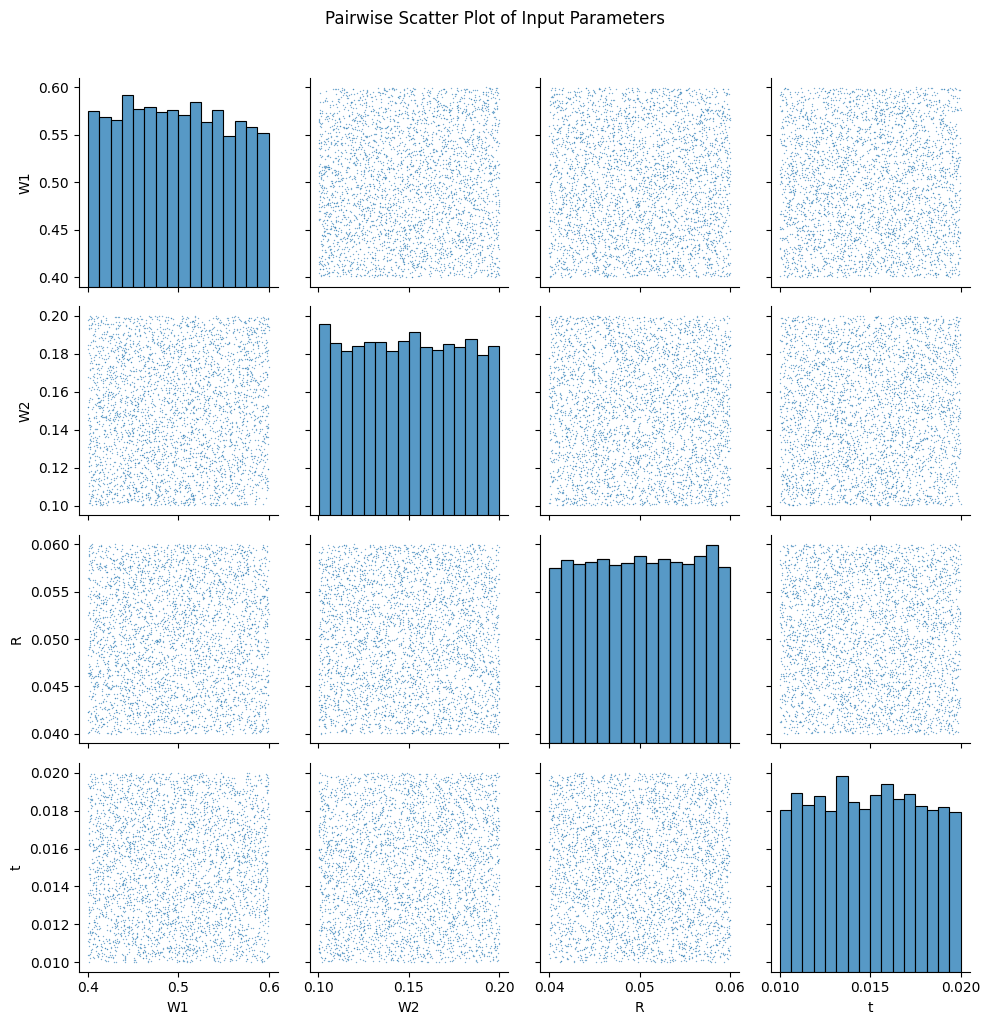

In [121]:
# --- Improved Pairwise Scatter Plot ---
sns.pairplot(
    df[['W1', 'W2', 'R', 't']],
    plot_kws={'s': 1, 'alpha': 0.6}  # smaller point size and some transparency
)
plt.suptitle("Pairwise Scatter Plot of Input Parameters", y=1.02)
plt.tight_layout()
plt.show()

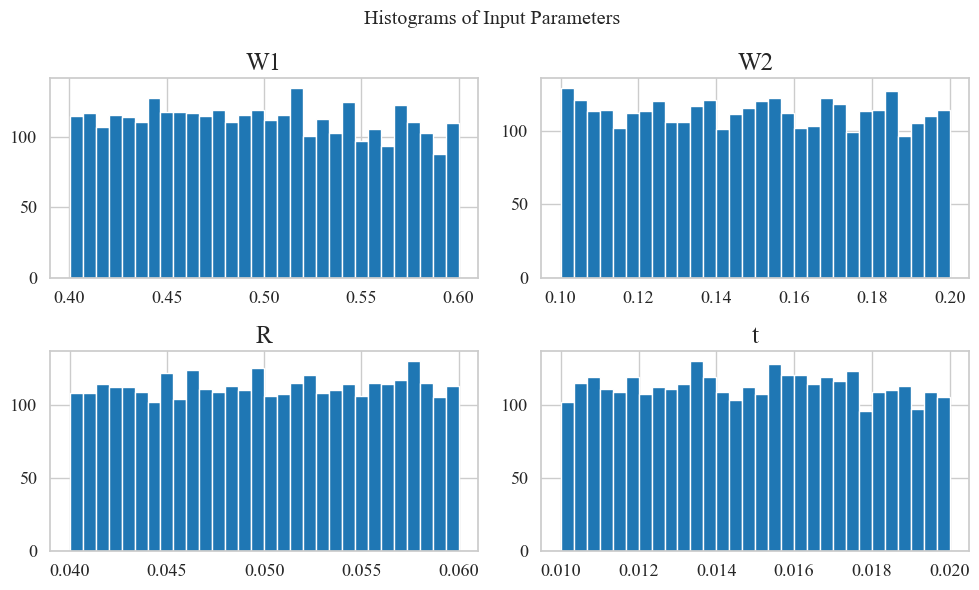

In [33]:
## Histograms
df[['W1', 'W2', 'R', 't']].hist(bins=30, figsize=(10, 6))
plt.suptitle("Histograms of Input Parameters")
plt.tight_layout()
plt.show()

# Gaussian Process Regression Model

## Data preparation:

In [110]:
#Shuffle the combined dataset first to get a representative sample
df_combined = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Select only the first 400 rows for kernel testing
df_gpr_comparison = df_combined.iloc[:400]

# Split the dataset into the input features and output stress
X = df_gpr_comparison[['W1', 'W2', 'R', 't']].values
Y = df_gpr_comparison['sigma_max'].values


# Normalising inputs to [0, 1] (helps GPR performance)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## Cross-Validation and Kernel Choice

In [8]:
# Define kernels (same as your original)
kernels = {
    "RBF": C(1.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4)),
    "RBF + WhiteKernel": (C(1.0, (1e-4, 1e4)) * RBF(1.0, (1e-4, 1e4))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1)),
    "Matern 32": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=1.5),
    "Matern 52": C(1.0, (1e-4, 1e4)) * Matern(length_scale=1.0, nu=2.5),
    "RBF (alpha=1e-4)": C(1.0, (1e-4, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e4))
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, kernel in kernels.items():
    if name == "RBF (alpha=1e-4)":
        gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-4, n_restarts_optimizer=15, normalize_y=True)
    else:
        gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)

    # Get predictions using cross_val_predict
    Y_pred = cross_val_predict(gpr, X_scaled, Y, cv=cv)
    
    # Compute metrics manually
    r2 = r2_score(Y, Y_pred)
    mae = mean_absolute_error(Y, Y_pred)
    mape = mean_absolute_percentage_error(Y, Y_pred)

    results[name] = {
        "r2": r2,
        "mae": mae,
        "mape": mape
    }

    print(f"{name}:")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  MAPE: {mape:.2%}")
    print()

# Summary
best_r2 = max(results.items(), key=lambda x: x[1]['r2'])
best_mae = min(results.items(), key=lambda x: x[1]['mae'])
best_mape = min(results.items(), key=lambda x: x[1]['mape'])

print("Summary of Best Kernels:")
print(f"  Highest R²:  {best_r2[0]} → {best_r2[1]['r2']:.4f}")
print(f"  Lowest MAE: {best_mae[0]} → {best_mae[1]['mae']:.4f}")
print(f"  Lowest MAPE: {best_mape[0]} → {best_mape[1]['mape']:.2%}")

RBF:
  R²:   0.9983
  MAE:  0.3351
  MAPE: 0.64%



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF + WhiteKernel:
  R²:   0.9999
  MAE:  0.0791
  MAPE: 0.14%



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better val

Matern 32:
  R²:   0.9997
  MAE:  0.1261
  MAPE: 0.22%



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Matern 52:
  R²:   0.9999
  MAE:  0.1049
  MAPE: 0.19%



/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RBF (alpha=1e-4):
  R²:   0.9999
  MAE:  0.0836
  MAPE: 0.15%

Summary of Best Kernels:
  Highest R²:  RBF + WhiteKernel → 0.9999
  Lowest MAE: RBF + WhiteKernel → 0.0791
  Lowest MAPE: RBF + WhiteKernel → 0.14%


In [22]:
# Set global font to Times New Roman and control default font size
plt.rcParams["font.family"] = "Times New Roman"

# Specifying text sizes used in the next sections
labelsize = 16
titlesize = 18
legendsize = 14

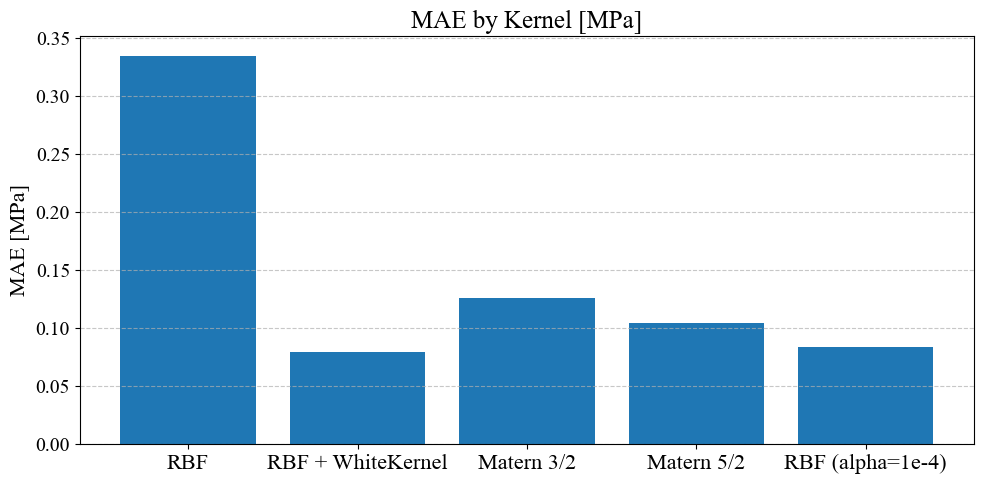

In [23]:
kernel_names = list(results.keys())
maes = [results[k]['mae'] for k in kernel_names]
mapes = [results[k]['mape'] for k in kernel_names]
r2s = [results[k]['r2'] for k in kernel_names]

kernel_labels = ['RBF', 'RBF + WhiteKernel', 'Matern 3/2', 'Matern 5/2', 'RBF (alpha=1e-4)']

plt.figure(figsize=(10, 5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar(kernel_labels, maes)
plt.xticks(fontsize=labelsize)
plt.ylabel("MAE [MPa]", fontsize = labelsize)
plt.title("MAE by Kernel [MPa]", fontsize = titlesize)
plt.tight_layout()
plt.savefig("figures/kernel_mae.png", dpi=600)
plt.show()

In [6]:
# Print out the results
print("Results: \n")
for _ in range(len(kernel_names)):
    print("-----------------------")
    print(f"kernel: {kernel_labels[_]}, R_2 = {r2s[_]}, MAE = {maes[_]}, MAPE = {mapes[_]}")

Results: 

-----------------------
kernel: RBF, R_2 = 0.9982849174686238, MAE = 0.3350674909703232, MAPE = 0.006423681782076438
-----------------------
kernel: RBF + WhiteKernel, R_2 = 0.9999244846647609, MAE = 0.07914265530690578, MAPE = 0.0014390846427795383
-----------------------
kernel: Matern 3/2, R_2 = 0.9996733983968119, MAE = 0.1261349344836688, MAPE = 0.002159237621305315
-----------------------
kernel: Matern 5/2, R_2 = 0.9998616974930739, MAE = 0.10489875182137094, MAPE = 0.0019341532251631176
-----------------------
kernel: RBF (alpha=1e-4), R_2 = 0.9999049806491312, MAE = 0.0836493103488347, MAPE = 0.0014993027212412482


## RBF + White Noise - determining the sample size

In [62]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

def evaluate_sample_efficiency(df, sample_sizes, repeats=15, eval_size=1000):
    assert 'runtime' in df.columns, "The dataset must include a 'runtime' column."

    # Extract input/output
    X_full = df[['W1', 'W2', 'R', 't']].values
    Y_full = df['sigma_max'].values
    time_full = df['runtime'].values

    # Split fixed evaluation set
    X_remain, X_eval, Y_remain, Y_eval, time_remain, _ = train_test_split(
        X_full, Y_full, time_full, test_size=eval_size, random_state=42
    )

    # Scale using only training data
    scaler = MinMaxScaler()
    X_remain_scaled = scaler.fit_transform(X_remain)
    X_eval_scaled = scaler.transform(X_eval)

    # Kernel
    kernel = (C(1.0, (1e-3, 1e5)) * RBF(1.0, (1e-4, 1e5))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))

    mae_results = []
    mape_results = []
    time_results = []

    for n in sample_sizes:
        maes = []
        mapes = []
        total_time = 0.0

        splitter = ShuffleSplit(n_splits=repeats, train_size=n, random_state=42)
        print(f"Evaluating sample size: {n}")

        for train_idx, _ in splitter.split(X_remain_scaled):
            X_train = X_remain_scaled[train_idx]
            Y_train = Y_remain[train_idx]
            time_train = time_remain[train_idx]

            total_time += np.sum(time_train)

            gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15, normalize_y=True)
            gpr.fit(X_train, Y_train)
            Y_pred = gpr.predict(X_eval_scaled)

            maes.append(mean_absolute_error(Y_eval, Y_pred))
            mapes.append(mean_absolute_percentage_error(Y_eval, Y_pred) * 100)  # Convert to percent

        mae_results.append(np.mean(maes))
        mape_results.append(np.mean(mapes))
        time_results.append(total_time / repeats / 3600)  # hours

    return {
        "sample_sizes": sample_sizes,
        "mae": mae_results,
        "mape": mape_results,
        "avg_sim_time": time_results
    }

In [113]:
start_time = time.time()
results = evaluate_sample_efficiency(df, sample_sizes=[100, 200, 300, 400, 500, 600, 800, 1000])
end_time = time.time()
kernel_selection_runtime_s = end_time - start_time

kernel_selection_runtime_h = kernel_selection_runtime_s / 3600

print(f"The total runtime for the cross validation was {kernel_selection_runtime_s:.4f} seconds or {kernel_selection_runtime_h:.4f} hours")

Evaluating sample size: 100


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 200


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 300


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Evaluating sample size: 400


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 500


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 600


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Evaluating sample size: 800


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Evaluating sample size: 1000


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

The total runtime for the cross validation was 541.0893 seconds or 0.1503 hours


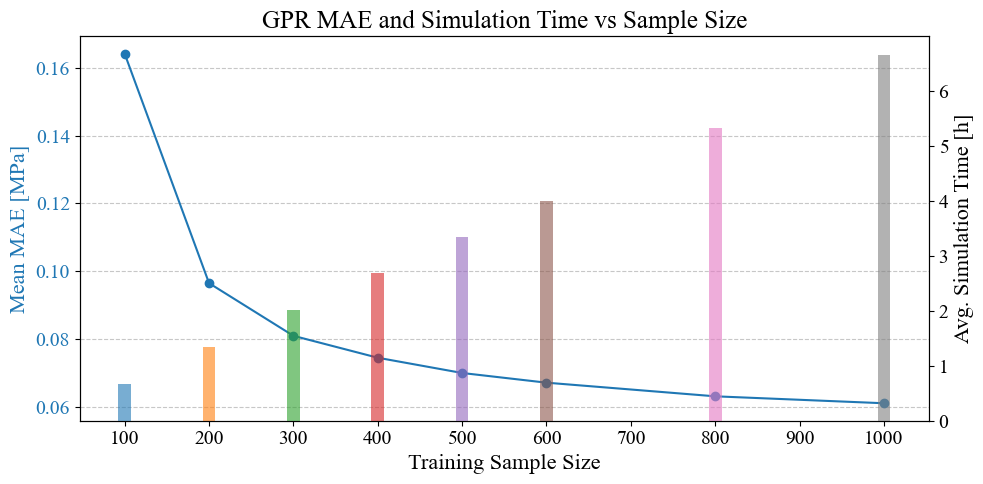

In [60]:
# Extract
sample_sizes = results["sample_sizes"]
maes = results["mae"]
sim_times = results["avg_sim_time"]

# Plot
cmap = plt.colormaps['tab10']  # Try 'Set3', 'Paired', 'tab10', 'viridis', etc.
colors = [cmap(i) for i in range(len(sample_sizes))]

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(sample_sizes, maes, marker='o', color='tab:blue', label='Mean MAE')
ax1.set_xlabel("Training Sample Size", fontsize = labelsize)
ax1.set_ylabel("Mean MAE [MPa]", color='tab:blue', fontsize = labelsize)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(np.arange(0, max(sample_sizes)+1, 100))
plt.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
ax2.bar(sample_sizes, sim_times, width=15, color=colors, alpha=0.6, label='Avg. Sim Time')
ax2.set_ylabel("Avg. Simulation Time [h]", color='black', fontsize = labelsize)
ax2.tick_params(axis='y')

plt.title("GPR MAE and Simulation Time vs Sample Size", fontsize=titlesize)
fig.tight_layout()
plt.savefig("figures/gpr_efficiency_combined.png", dpi=300)
plt.show()

In [64]:
print("\n GPR Model Evaluation Summary")
print("────────────────────────────────────────────")
print(f"{'Samples':>10} | {'MAE':>10} | {'MAPE (%)':>10} | {'Time (h)':>10}")
print("────────────────────────────────────────────")
for n, mae, mape, time in zip(results['sample_sizes'],
                              results['mae'],
                              results['mape'],
                              results['avg_sim_time']):
    print(f"{n:>10} | {mae:>10.4f} | {mape:>10.2f} | {time:>10.2f}")
print("────────────────────────────────────────────")


 GPR Model Evaluation Summary
────────────────────────────────────────────
   Samples |        MAE |   MAPE (%) |   Time (h)
────────────────────────────────────────────
       100 |     0.1641 |       0.30 |       0.66
       200 |     0.0965 |       0.17 |       1.33
       300 |     0.0810 |       0.15 |       2.01
       400 |     0.0745 |       0.14 |       2.68
       500 |     0.0700 |       0.13 |       3.34
       600 |     0.0672 |       0.12 |       4.00
       800 |     0.0631 |       0.12 |       5.33
      1000 |     0.0611 |       0.11 |       6.65
────────────────────────────────────────────


# Final GPR Model Training:

In [65]:
final_gpr_train_start = time.time()

# --- PARAMETERS ---
n_final_samples = 400
model_dir = "models"
data_dir = "data"

# --- Sample and preprocess ---
df_final = df.sample(n=n_final_samples, random_state=42).reset_index(drop=True)
X = df_final[['W1', 'W2', 'R', 't']].values
Y = df_final['sigma_max'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- Define and train GPR ---
kernel = (C(1.0, (1e-3, 1e5)) * RBF(1.0, (1e-4, 1e5))) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True)
gpr.fit(X_scaled, Y)

# --- Save model, scaler, and training dataset ---
joblib.dump(gpr, f"{model_dir}/final_gpr_model.pkl")
joblib.dump(scaler, f"{model_dir}/final_scaler.pkl")
df_final.to_csv(f"{data_dir}/final_gpr_training_data.csv", index=False)

print(f"Final GPR model and scaler saved to '{model_dir}/'")
print(f"Training dataset saved to '{data_dir}/final_gpr_training_data.csv'")

/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Final GPR model and scaler saved to 'models/'
Training dataset saved to 'data/final_gpr_training_data.csv'


# Final GPR Model Evaluation

In [70]:
# --- Load trained model, scaler, and training data ---

# Paths
model_path = f"models/final_gpr_model.pkl"
scaler_path = f"models/final_scaler.pkl"
train_data_path = f"data/final_gpr_training_data.csv"

# Load components
gpr = joblib.load(model_path)
scaler = joblib.load(scaler_path)
df_train = pd.read_csv(train_data_path)

# Create evaluation set: all data not used in training
df_eval = df.drop(df_train.index, axis=0).reset_index(drop=True)

In [73]:
# Extract inputs and targets from evaluation set
X_eval = df_eval[['W1', 'W2', 'R', 't']].values
Y_eval = df_eval['sigma_max'].values
X_eval_scaled = scaler.transform(X_eval)

# Predict
Y_pred = gpr.predict(X_eval_scaled)

r2 = r2_score(Y_eval, Y_pred)
mae = mean_absolute_error(Y_eval, Y_pred)
mape = mean_absolute_percentage_error(Y_eval, Y_pred) * 100  # in %

print(f"Final GPR Evaluation:")
print(f"  R²   = {r2:.4f}")
print(f"  MAE  = {mae:.4f} MPa")
print(f"  MAPE = {mape:.2f}%")

Final GPR Evaluation:
  R²   = 0.9999
  MAE  = 0.0724 MPa
  MAPE = 0.14%


In [83]:
residuals = Y_pred - Y_eval
mean_residual = np.mean(residuals)
print(f"Mean Residual: {mean_residual:.4f} MPa")
skewness = skew(residuals)
print(f"Residual Skewness: {skewness:.4f}")
prop_over = np.mean(residuals > 0)
prop_under = np.mean(residuals < 0)
print(f"Overpredictions: {prop_over*100:.1f}%")
print(f"Underpredictions: {prop_under*100:.1f}%")

Mean Residual: 0.0024 MPa
Residual Skewness: -3.2358
Overpredictions: 49.9%
Underpredictions: 50.1%


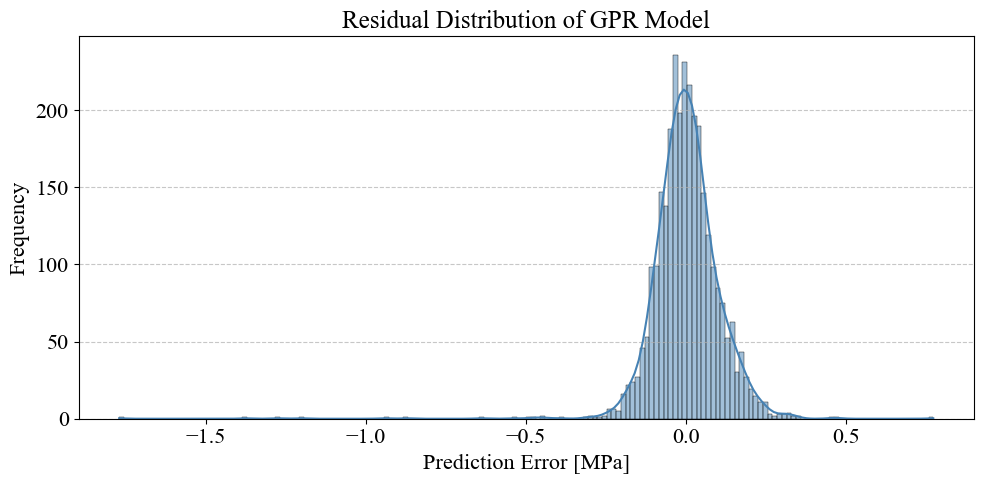

In [85]:
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='steelblue')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Prediction Error [MPa]", fontsize=labelsize)
plt.ylabel("Frequency", fontsize=labelsize)
plt.xticks(fontsize=labelsize)
plt.yticks(fontsize=labelsize)
plt.title("Residual Distribution of GPR Model", fontsize=titlesize)
plt.tight_layout()
plt.savefig("figures/final_gpr_residuals.png", dpi=600)
plt.show()

# Neural Network

## Key Hyperparameters in This Code

| Hyperparameter         | Line(s)               | Notes |
|------------------------|-----------------------|-------|
| Architecture (layers, neurons) | `Dense(32)`, `Dense(16)`, `Dense(1)` | Core design of NN |
| Activation functions   | `activation='relu'`   | Could try `tanh`, `elu`, etc. |
| Optimizer              | `'adam'`              | Could try SGD, RMSprop, etc. |
| Loss function          | `'mse'`               | Could try `'mae'`, `'huber'` |
| Epochs                 | `epochs=200`          | Max training time |
| Batch size             | `batch_size=32`       | Affects convergence speed |
| Early stopping patience| `patience=10`         | When to stop if no val improvement |
| Validation split ratio | `train_test_split(...)` | Controls size of val set |

# Keras Tuner Hyperparameter Search

In [16]:
# --- Data ---
X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values

# Scale inputs and outputs
input_scaler = StandardScaler()
output_scaler = StandardScaler()
X_scaled = input_scaler.fit_transform(X)
y_scaled = output_scaler.fit_transform(y.reshape(-1, 1))

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# --- Define model builder function ---
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))

    # Tune number of layers and units
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=16),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
            )
        )
    
    model.add(layers.Dense(1))  # Output layer

    model.compile(
        optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]),
        loss="mse",
        metrics=["mae"]
    )
    
    return model

# --- Initialize tuner ---
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory="keras_tuner",
    project_name="regression_model"
)

# --- Early stopping ---
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# --- Search ---
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- Retrieve best model ---
best_model = tuner.get_best_models(1)[0]

# --- Evaluate ---
y_pred_scaled = best_model.predict(X_val)
y_pred = output_scaler.inverse_transform(y_pred_scaled)
y_val_true = output_scaler.inverse_transform(y_val)

mae = mean_absolute_error(y_val_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_val_true, y_pred))
print(f"Best model performance → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Trial 20 Complete [00h 00m 33s]
val_mae: 0.01845935545861721

Best val_mae So Far: 0.00673348642885685
Total elapsed time: 00h 13m 59s
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Best model performance → MAE: 0.0971, RMSE: 0.1727


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
best_trial = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
for param in best_trial.values:
    print(f"{param}: {best_trial.get(param)}")

Best hyperparameters:
num_layers: 2
units_0: 96
activation: sigmoid
optimizer: adam
units_1: 16


# Well Tuned Neural Network

In [122]:
final_nn_start = time.time()

# --- Reproducibility ---
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

X = df[['W1', 'W2', 'R', 't']].values
y = df['sigma_max'].values.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# --- Scale inputs and outputs ---
input_scaler = StandardScaler()
output_scaler = StandardScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_val_scaled = input_scaler.transform(X_val)
X_test_scaled = input_scaler.transform(X_test)

y_train_scaled = output_scaler.fit_transform(y_train)
y_val_scaled = output_scaler.transform(y_val)
y_test_scaled = output_scaler.transform(y_test)

# --- Build model using best hyperparameters ---
model = keras.Sequential([
    layers.Dense(96, activation='sigmoid', input_shape=(4,)),  # Layer 1
    layers.Dense(16, activation='sigmoid'),                    # Layer 2
    layers.Dense(1)                                            # Output layer
])

model.compile(
    optimizer='adam',     # Best found optimizer
    loss='mse',
    metrics=['mae']
)

# --- Callbacks ---
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

lr_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5
)

# --- Train ---
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=500,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

final_nn_end = time.time()
final_nn_runtime = final_nn_end - final_nn_start

print(f"The final runtime for the nn model was {final_nn_runtime:.4f} seconds")

# --- Save model + scalers ---
os.makedirs("models", exist_ok=True)
model.save("models/nn_model.keras")
joblib.dump(input_scaler, "models/nn_input_scaler.pkl")
joblib.dump(output_scaler, "models/nn_output_scaler.pkl")
df_test_save = pd.DataFrame(X_test, columns=['W1', 'W2', 'R', 't'])
df_test_save['sigma_max_true'] = y_test.flatten()
df_test_save.to_csv("data/nn_test_data.csv", index=False)

print("\nModel, dataset and scalers saved to 'models/' folder.")

Epoch 1/500


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9644 - mae: 0.7791 - val_loss: 0.7602 - val_mae: 0.6872 - learning_rate: 0.0010
Epoch 2/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6099 - mae: 0.6100 - val_loss: 0.3292 - val_mae: 0.4372 - learning_rate: 0.0010
Epoch 3/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2136 - mae: 0.3370 - val_loss: 0.0806 - val_mae: 0.1714 - learning_rate: 0.0010
Epoch 4/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0559 - mae: 0.1459 - val_loss: 0.0536 - val_mae: 0.1348 - learning_rate: 0.0010
Epoch 5/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 - mae: 0.1310 - val_loss: 0.0471 - val_mae: 0.1263 - learning_rate: 0.0010
Epoch 6/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0363 - mae: 0.1224 - val_loss: 0.0420 - val_mae: 0.1183 - learning_rate: 0.0010
Epoch 7/500
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0321 - mae: 0.1152 - val_loss: 0.0379 - val_mae: 0.1124 - learning_rate: 0.0010
Epoch 8/500
74/74 ━━━━━━━

In [100]:
# Load model and scalers
model = keras.models.load_model("models/nn_model.keras")
input_scaler = joblib.load("models/nn_input_scaler.pkl")
output_scaler = joblib.load("models/nn_output_scaler.pkl")
df_test = pd.read_csv("data/nn_test_data.csv")

# Prepare data
X_test = df_test[['W1', 'W2', 'R', 't']].values
y_true = df_test['sigma_max_true'].values.reshape(-1, 1)
X_test_scaled = input_scaler.transform(X_test)

# Predict and inverse scale
y_pred_scaled = model.predict(X_test_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2 = r2_score(y_true, y_pred)

# Print results
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE:  0.1051
RMSE: 0.1857
MAPE: 0.19%
R²:   0.9998


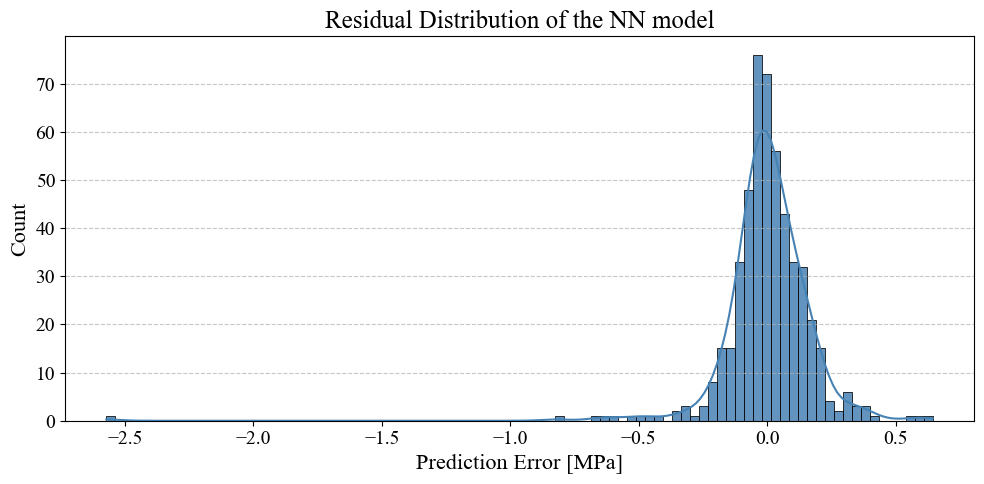

Mean Residual: 0.0011359968639726254 MPa
Residual Skewness: -5.441436298291127
Overpredictions: 49.3%
Underpredictions: 50.7%


In [101]:
# --- Residual Analysis ---
residuals = y_pred.flatten() - y_true.flatten()

# Plot: Histogram + KDE
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='steelblue', alpha=0.85)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Prediction Error [MPa]", fontsize=labelsize)
plt.ylabel("Count", fontsize=labelsize)
plt.title("Residual Distribution of the NN model", fontsize=titlesize)
plt.tight_layout()
plt.savefig("figures/nn_residuals.png", dpi=600)
plt.show()

# --- Residual Statistics ---
skewness = skew(residuals)
mean_res = np.mean(residuals)
percent_over = np.sum(residuals > 0) / len(residuals) * 100
percent_under = np.sum(residuals < 0) / len(residuals) * 100

print(f"Mean Residual: {mean_res:} MPa")
print(f"Residual Skewness: {skewness:}")
print(f"Overpredictions: {percent_over:.1f}%")
print(f"Underpredictions: {percent_under:.1f}%")

# Time Calculations

In [128]:
#GPR
gpr_training_dataset = pd.read_csv('data/gpr_training_data.csv')

gpr_dataset_runtime_s = np.sum(gpr_training_dataset["runtime"])
gpr_pareto_front = 1.82 
final_gpr_training = 0.6
kernel_cross_validation = 541.10

full_gpr_time_s = gpr_dataset_runtime_s + gpr_pareto_front + final_gpr_training + kernel_cross_validation
full_gpr_time_h = full_gpr_time_s / 3600

print(f"The total time required to create the GPR model was {full_gpr_time_s:.4f} seconds or {total_time_h:.4f} hours.")

# NN
nn_test_dataset = pd.read_csv('data/nn_test_data.csv')
# Remove test rows from full dataset to get training + validation set
nn_training_dataset = pd.concat([df, nn_test_dataset, nn_test_dataset]).drop_duplicates(keep=False)

nn_dataset_runtime = nn_training_dataset["runtime"].sum()
nn_pareto_front = 4.22
hyperparameter_search = 14*60
final_nn_training = 255.76 

full_nn_time_s = nn_dataset_runtime + nn_pareto_front + hyperparameter_search + final_nn_training
full_nn_time_h = full_nn_time_s / 3600


print(f"The total time required to generate the dataset for the NN was {full_nn_time_s:.4f} seconds or {full_nn_time_h:.4f} hours.")

The total time required to create the GPR model was 10485.0960 seconds or 2.7615 hours.
The total time required to generate the dataset for the NN was 82854.3080 seconds or 23.0151 hours.


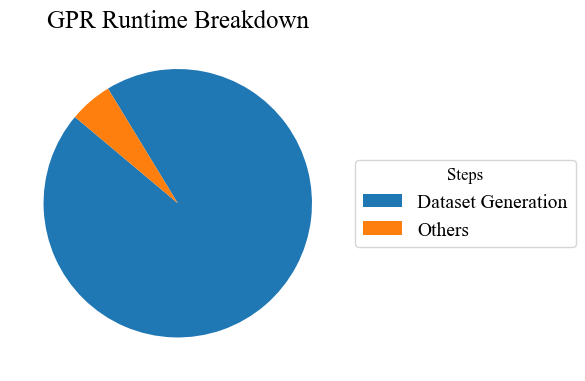

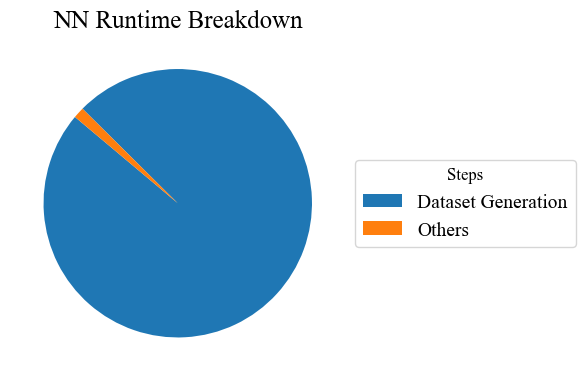

In [132]:
def plot_runtime_pie(title, labels, sizes, threshold=0.1, save_path="pie.png"):
    # Normalize sizes and combine small slices
    total = sum(sizes)
    sizes = np.array(sizes)
    labels = np.array(labels)
    
    mask = sizes / total >= threshold
    main_labels = labels[mask]
    main_sizes = sizes[mask]
    
    other_size = sizes[~mask].sum()
    if other_size > 0:
        main_labels = np.append(main_labels, "Others")
        main_sizes = np.append(main_sizes, other_size)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts = ax.pie(main_sizes, startangle=140)
    ax.set_title(title)

    # Add legend
    ax.legend(wedges, main_labels, title="Steps", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=legendsize)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


# --- GPR ---
gpr_labels = ['Dataset Generation', 'Kernel Cross-Validation', 'Final Model Training', 'Pareto Optimisation']
gpr_sizes = [gpr_dataset_runtime_s, kernel_cross_validation, final_gpr_training, gpr_pareto_front]

plot_runtime_pie(
    "GPR Runtime Breakdown",
    gpr_labels,
    gpr_sizes,
    save_path="figures/gpr_runtime_pie.png"
)

# --- NN ---
nn_labels = ['Dataset Generation', 'Hyperparameter Search', 'Final Model Training', 'Pareto Optimisation']
nn_sizes = [nn_dataset_runtime, hyperparameter_search, final_nn_training, nn_pareto_front]

plot_runtime_pie(
    "NN Runtime Breakdown",
    nn_labels,
    nn_sizes,
    save_path="figures/nn_runtime_pie.png"
)

In [136]:
whole_dataset_runtime = np.sum(df["runtime"])
rows, _ = df.shape
average_fea_runtime = whole_dataset_runtime / rows
print(f"On average, one simulation took {average_fea_runtime:.4f} seconds.")

On average, one simulation took 24.2020 seconds.


In [159]:
# Load test dataset and models
df_test = pd.read_csv("data/nn_test_data.csv")
X_test = df_test[['W1', 'W2', 'R', 't']].values
input_scaler = joblib.load("models/nn_input_scaler.pkl")
output_scaler = joblib.load("models/nn_output_scaler.pkl")

X_test_scaled = input_scaler.transform(X_test[:100])  # Use first 100 for timing
gpr = joblib.load("models/final_gpr_model.pkl")
nn_model = keras.models.load_model("models/nn_model.keras")

# Average FEA time (from dataset)
avg_fea_time = df["runtime"].mean()

# GPR prediction time
start = time.time()
gpr.predict(X_test_scaled)
gpr_time = (time.time() - start) / len(X_test_scaled)

# NN prediction time
start = time.time()
nn_model.predict(X_test_scaled)
nn_time = (time.time() - start) / len(X_test_scaled)

# Speedups
gpr_speedup = avg_fea_time / gpr_time
nn_speedup = avg_fea_time / nn_time

print(f"Average FEA runtime: {avg_fea_time:.6f} s")
print(f"Average GPR prediction time: {gpr_time:.7f} s, Speedup: {gpr_speedup:.1f}")
print(f"Average NN prediction time: {nn_time:.7f} s, Speedup: {nn_speedup:.1f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Average FEA runtime: 24.201992 s
Average GPR prediction time: 0.0000273 s, Speedup: 886864.5
Average NN prediction time: 0.0013979 s, Speedup: 17313.7
